In [31]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
# reference https://github.com/rlabbe/filterpy

# visualiation
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [29]:
# read CSV file
traj_lens = np.loadtxt('./Trajectory/data/traj_lens.csv')
print(f"number of trajectories = {len(traj_lens)}")

traj_start = np.zeros((len(traj_lens)+1,1), dtype=int)
# traj_end = np.zeros((len(traj_lens),1))
idx = 1
for length in traj_lens[:]:
    traj_start[idx] = traj_start[idx - 1] + length
    # traj_end[idx-1] = traj_start[idx] - 1
    idx = idx + 1

# traj_end[-1] = traj_lens[-1] + traj_end[-2] - 1

original_position_list = np.loadtxt('./Trajectory/data/original_position_list.csv')
position_noise_1 = np.loadtxt('./Trajectory/data/position_noise_1.csv')

print(original_position_list.shape)

number of trajectories = 100
(65900, 3)


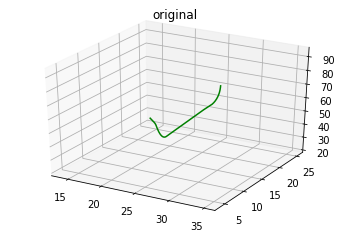

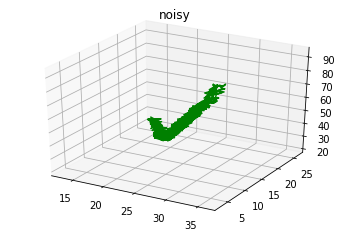

In [34]:
traject_select = 23

original = original_position_list[traj_start[traject_select][0]: traj_start[traject_select+1][0]][:]
noisy = position_noise_1[traj_start[traject_select][0]: traj_start[traject_select+1][0]][:]

def plot_trajectory(x, title):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.plot3D(xline, yline, zline, 'green')

plot_trajectory(original, "original")
plot_trajectory(noisy, "noisy")

In [80]:
dt = 0.01 # constant sampling time

filter = KalmanFilter(dim_x=6, dim_z=3) # internal state has x,y,z,vx,vy,vz

# transition matrix
filter.F = np.array([
    [1, 0, 0, dt, 0, 0],
    [0, 1, 0, 0, dt, 0],
    [0, 0, 1, 0, 0, dt],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]]
)

# measurement matrix
filter.H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0]]
)

## tunable parameters

# covariance matrix
filter.P *= 1000 


# measurement noise
filter.R = np.diag([1, 1, 1])

# process noise
filter.Q = np.diag([1e-4,1e-4,1e-4, 1e-3, 1e-3, 1e-3]) #Q_discrete_white_noise(3, dt, .1)



In [82]:
# feeding data to kalman filter

# initialise the state
initial_guess = np.concatenate([noisy[0],np.array([0,0,0])])
filter.x = initial_guess


# prediction
filtered = np.zeros((original.shape[0],6))
filtered[0] = initial_guess # no filter available yet
for i in range(1,original.shape[0]):
    filter.predict()
    filter.update(noisy[i])

    filtered[i] = filter.x
    if (i % 50 == 1):
        print(i)
        print(filter.P)

    

1
[[0.00532993 0.         0.         0.00972985 0.         0.        ]
 [0.         0.00532993 0.         0.         0.00972985 0.        ]
 [0.         0.         0.00532993 0.         0.         0.00972985]
 [0.00972985 0.         0.         0.0547791  0.         0.        ]
 [0.         0.00972985 0.         0.         0.0547791  0.        ]
 [0.         0.         0.00972985 0.         0.         0.0547791 ]]
51
[[0.00532993 0.         0.         0.00972985 0.         0.        ]
 [0.         0.00532993 0.         0.         0.00972985 0.        ]
 [0.         0.         0.00532993 0.         0.         0.00972985]
 [0.00972985 0.         0.         0.0547791  0.         0.        ]
 [0.         0.00972985 0.         0.         0.0547791  0.        ]
 [0.         0.         0.00972985 0.         0.         0.0547791 ]]
101
[[0.00532993 0.         0.         0.00972985 0.         0.        ]
 [0.         0.00532993 0.         0.         0.00972985 0.        ]
 [0.         0.        

[[ 1.34110532e+01  2.56544373e+01  2.66820833e+01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.34747089e+01  2.56247451e+01  2.66652805e+01  1.16204361e-01
  -5.42034343e-02 -3.06738288e-02]
 [ 1.35260201e+01  2.55479994e+01  2.66413073e+01  2.07752492e-01
  -1.93314365e-01 -7.38772139e-02]
 ...
 [ 3.48204526e+01  7.23305743e+00  9.53713768e+01  3.97609503e-01
   3.72293199e+00  9.14086061e+00]
 [ 3.48322200e+01  7.30389668e+00  9.54245382e+01  4.11832611e-01
   3.78428736e+00  9.07103977e+00]
 [ 3.47804973e+01  7.34437420e+00  9.54929349e+01  3.09893957e-01
   3.78909695e+00  9.03030595e+00]]


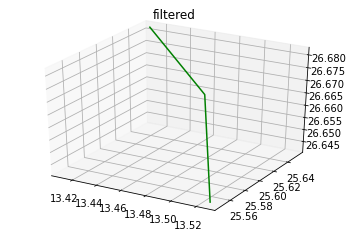

In [83]:
print(filtered)
plot_trajectory(filtered[:][0:3],"filtered")